In [1]:
# -*- coding: utf-8 -*-
import graphlab, os, pickle, sys, re
from collections import defaultdict, Counter
from scipy.spatial.distance import cosine
from operator import itemgetter
import numpy as np
from data_util import *

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1504215436.log


This non-commercial license of GraphLab Create for academic use is assigned to iacz489@gmail.com and will expire on October 08, 2017.


# Generating Working Datasets for Prediction

 ('web_id',
 'url',
 'content',
 'entry',
 'suggests',
 'suggest_ranks',
 'topic',
 'topic_probability',
 'token') 
 ## =>
 ('web_id',
 'url',
 'content',
 'entry',
 'suggests',
 'suggest_ranks',
 'topic',
 'topic_probability',
 'token',
 'vec_doc',
 'suggest_f',
 'label',
 'sKeyWord_5',
 'vec_sKeyWord_5',
 'sKeyWord_wikiOnly_5',
 'vec_sKeyWord_wikiOnly_5',
 'sKeyWord_8',
 'vec_sKeyWord_8',
 'sKeyWord_wikiOnly_8',
 'vec_sKeyWord_wikiOnly_8',
 'sKeyWord_10',
 'vec_sKeyWord_10',
 'sKeyWord_wikiOnly_10',
 'vec_sKeyWord_wikiOnly_10')

In [2]:
qf_name_dict = dict([("kafunsyo", "花粉症"), ("kekkon", "結婚"), ("syukatsu", "就活"), ("3dprinter", "3dプリンタ"), ("mansion", "マンション")])
qf_names = ["syukatsu", "kekkon", "kafunsyo", "mansion"]
qf_paths = [os.path.join(os.getcwd(), "qf_sframes_readonly", qf) for qf in qf_names]
sf_list = []
for path in qf_paths:
    sf_list.append(graphlab.SFrame(path))

In [3]:
SERIAL_DIR = os.path.join(os.getcwd(), "serialization")
W2V_DIR = os.path.join(os.getcwd(), "word2vec")
D2V_DIR = os.path.join(os.getcwd(), "doc2vec")
WORKING_DATA_FRAME_DIR = os.path.join(os.getcwd(), "working_data")

In [4]:
try:
    os.stat(SERIAL_DIR)
except OSError:
    os.mkdir(SERIAL_DIR)

In [5]:
for qf_name, sf in zip(qf_names, sf_list):
    print qf_name
    sf["vec_doc"] = DataUtility.get_doc_vec_col(os.path.join(D2V_DIR, "doc2vec_model_%s"%qf_name))
    pickle.dump(list(sf["vec_doc"]), open(os.path.join(SERIAL_DIR, "vec_doc_%s"%qf_name,), 'w'))
    sf["suggest_f"] = DataUtility.get_suggest_f_col(sf)
    set_valid_suggest_words = DataUtility.extract_one_segment_suggest_keywords(sf, qf_name_dict[qf_name])
    pickle.dump(set_valid_suggest_words, open(os.path.join(SERIAL_DIR, "set_valid_suggest_words_%s"%qf_name), "w"))
    for size in [5, 8, 10]:
        dict_wiki_w2v = DataUtility.get_dict_suggest_word_vec(set_valid_suggest_words,\
                                                          os.path.join(W2V_DIR, "trained_models", "model_%d_%s.model"%(size, qf_name)))
        pickle.dump(dict_wiki_w2v, open(os.path.join(SERIAL_DIR, "suggest_word_vec_%s_size_%d"%(qf_name, size)), "w"))
        dict_wiki_w2v = DataUtility.get_dict_suggest_word_vec(set_valid_suggest_words,\
                                                          os.path.join(W2V_DIR, "trained_models", "model_%d_no_%s.model"%(size, qf_name)))
        pickle.dump(dict_wiki_w2v, open(os.path.join(SERIAL_DIR, "suggest_word_vec_no_%s_size_%d"%(qf_name, size)), "w"))
    print "done with serialization"
    sf_labelled = DataUtility.create_labeled_doc_set(sf, graphlab.SFrame("label_%s.csv"%qf_name))
    for size in [5, 8, 10]:
        suggest_word_vec = pickle.load(open(os.path.join(SERIAL_DIR, "suggest_word_vec_%s_size_%d"%(qf_name, size)), "r"))
        sf_labelled["sKeyWord_%d"%size] = DataUtility.get_valid_sKeyWord_col(sf_labelled, qf_name_dict[qf_name], suggest_word_vec)
        sf_labelled["vec_sKeyWord_%d"%size] = DataUtility.get_valid_sKeyWord_vec_col(sf_labelled, qf_name_dict[qf_name], suggest_word_vec)
        suggest_word_vec_no = pickle.load(open(os.path.join(SERIAL_DIR, "suggest_word_vec_no_%s_size_%d"%(qf_name, size)), "r"))
        sf_labelled["sKeyWord_wikiOnly_%d"%size] = DataUtility.get_valid_sKeyWord_col(sf_labelled, qf_name_dict[qf_name], suggest_word_vec_no)
        sf_labelled["vec_sKeyWord_wikiOnly_%d"%size] = DataUtility.get_valid_sKeyWord_vec_col(sf_labelled, qf_name_dict[qf_name], suggest_word_vec_no)

    print qf_name, "dumping d2d_vsim..."
    dict_d2d_vsim = DataUtility.get_d2d_vsim_matrix(sf_labelled)
    pickle.dump(dict_d2d_vsim, open(os.path.join(SERIAL_DIR, "d2d_vsim_%s"%qf_name), 'w'))
    print qf_name, "dumping d2d_wsim..."
    dict_d2d_sim = DataUtility.get_d2d_sim_matrix(sf_labelled, "token")
    pickle.dump(dict_d2d_sim, open(os.path.join(SERIAL_DIR, "d2d_wsim_%s"%qf_name), 'w'))
    
    try:
        os.stat(WORKING_DATA_FRAME_DIR)
    except OSError:
        os.mkdir(WORKING_DATA_FRAME_DIR)
    sf_labelled.save(os.path.join(WORKING_DATA_FRAME_DIR, qf_name))
    

syukatsu
done with serialization


Finished parsing file /Volumes/SONY_1TB/research/journal_related_new_data/label_syukatsu.csv

Parsing completed. Parsed 100 lines in 0.021958 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Volumes/SONY_1TB/research/journal_related_new_data/label_syukatsu.csv

Parsing completed. Parsed 2951 lines in 0.011328 secs.

syukatsu dumping d2d_vsim...
syukatsu dumping d2d_sim...
kekkon
done with serialization


Finished parsing file /Volumes/SONY_1TB/research/journal_related_new_data/label_kekkon.csv

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Parsing completed. Parsed 100 lines in 0.021956 secs.

Finished parsing file /Volumes/SONY_1TB/research/journal_related_new_data/label_kekkon.csv

Parsing completed. Parsed 3540 lines in 0.011811 secs.

kekkon dumping d2d_vsim...
kekkon dumping d2d_sim...
kafunsyo
done with serialization


Finished parsing file /Volumes/SONY_1TB/research/journal_related_new_data/label_kafunsyo.csv

Parsing completed. Parsed 100 lines in 0.021691 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Volumes/SONY_1TB/research/journal_related_new_data/label_kafunsyo.csv

Parsing completed. Parsed 2955 lines in 0.012187 secs.

kafunsyo dumping d2d_vsim...
kafunsyo dumping d2d_sim...
mansion
done with serialization


Finished parsing file /Volumes/SONY_1TB/research/journal_related_new_data/label_mansion.csv

Parsing completed. Parsed 100 lines in 0.022558 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /Volumes/SONY_1TB/research/journal_related_new_data/label_mansion.csv

Parsing completed. Parsed 3000 lines in 0.013154 secs.

mansion dumping d2d_vsim...
mansion dumping d2d_sim...


# Prediction Jobs Below

In [2]:
from unsupervised_models import *

In [3]:
SERIAL_DIR = os.path.join(os.getcwd(), "serialization")
WORKING_DATA_FRAME_DIR = os.path.join(os.getcwd(), "working_data")

In [6]:
qf_names = ["syukatsu", "kekkon", "kafunsyo", "mansion"]
qf_name_dict = dict([("kafunsyo", "花粉症"), ("kekkon", "結婚"), ("syukatsu", "就活"), ("3dprinter", "3dプリンタ"), ("mansion", "マンション")])
qf_paths = [os.path.join(WORKING_DATA_FRAME_DIR, name) for name in qf_names]
sf_list = []
for path in qf_paths:
    sf_list.append(graphlab.SFrame(path))
#set_conf = set([line.strip() for line in open("predict.conf", 'r') if len(line)>0 and not line[0]=='#'])

In [7]:
for name, sf in zip(qf_names, sf_list):
    sf.save("%s.csv"%name)

In [2]:
def predict(qf_name, sf, window_size):
    d2d_vsim = pickle.load(open(os.path.join(SERIAL_DIR, "d2d_vsim_%s"%qf_name)))
    d2d_wsim = pickle.load(open(os.path.join(SERIAL_DIR, "d2d_wsim_%s"%qf_name)))
    predictor = UnsupervisedPredictor(d2d_vsim=d2d_vsim, d2d_wsim=d2d_wsim, list_sframe_topic=DataUtility.make_list_by_topic(sf))
    predictor.qf_name = qf_name
    predictor.qf_name_JPC = qf_name_dict[qf_name]
    sa_list_label = [sf_t["label"] for sf_t in predictor.list_sframe_topic]
    eval_stat = defaultdict(list)
    
    for lbd in np.arange(-1.0, 1.02, 0.02):
        print qf_name, "lbd =", lbd
        #eval_stat["lbd"].append(lbd)
        if "predict_subtopics_on_vec_doc" in set_conf:
            sa_list_prediction_doc = predictor.predict_subtopics_on_vec_doc(SIM_LB=lbd)
            evaluator = Evaluator(sa_list_prediction=sa_list_prediction_doc, sa_list_label=sa_list_label)
            #eval_stat["accuracy_doc"].append(evaluator.get_accuracy())
            micro_p_r = evaluator.get_micro_pre_rec()
            eval_stat["p_doc"].append(micro_p_r[0])
            eval_stat["r_doc"].append(micro_p_r[1])
            del evaluator
            del sa_list_prediction_doc
            
        if "predict_subtopics_on_sKeyWord" in set_conf:
            sa_list_prediction_sKeyWord = predictor.predict_subtopics_on_sKeyWord_vec("vec_sKeyWord_%d"%window_size, SIM_LB=lbd)
            evaluator = Evaluator(sa_list_prediction=sa_list_prediction_sKeyWord, sa_list_label=sa_list_label)
            #eval_stat["accuracy_sKeyWord"].append(evaluator.get_accuracy())
            micro_p_r = evaluator.get_micro_pre_rec()
            #print "sKeyWord", micro_p_r[0], micro_p_r[1]
            eval_stat["p_sKeyWord"].append(micro_p_r[0])
            eval_stat["r_sKeyWord"].append(micro_p_r[1])
            del evaluator
            del sa_list_prediction_sKeyWord

        if "predict_subtopics_on_sKeyWord_wikiOnly" in set_conf:
            sa_list_prediction_sKeyWord_wikiOnly = predictor.predict_subtopics_on_sKeyWord_vec("vec_sKeyWord_wikiOnly_%d"%window_size, SIM_LB=lbd)
            evaluator = Evaluator(sa_list_prediction=sa_list_prediction_sKeyWord_wikiOnly, sa_list_label=sa_list_label)
            #eval_stat["accuracy_sKeyWord_wikiOnly"].append(evaluator.get_accuracy())
            micro_p_r = evaluator.get_micro_pre_rec()
            #print "sKeyWord_wikiOnly", micro_p_r[0], micro_p_r[1]
            eval_stat["p_sKeyWord_wikiOnly"].append(micro_p_r[0])
            eval_stat["r_sKeyWord_wikiOnly"].append(micro_p_r[1])
            del evaluator
            del sa_list_prediction_sKeyWord_wikiOnly
            
        if "predict_subtopics_on_bow" in set_conf:    
            sa_list_prediction_bow = predictor.predict_subtopics_on_bow(SIM_LB=lbd)
            evaluator = Evaluator(sa_list_prediction=sa_list_prediction_bow, sa_list_label=sa_list_label)
            #eval_stat["accuracy_sKeyWord_bow"].append(evaluator.get_accuracy())
            micro_p_r = evaluator.get_micro_pre_rec()
            #print "sKeyWord_wikiOnly", micro_p_r[0], micro_p_r[1]
            eval_stat["p_bow"].append(micro_p_r[0])
            eval_stat["r_bow"].append(micro_p_r[1])
            del evaluator
            del sa_list_prediction_bow
            
    if "predict_subtopics_on_topic_ranking" in set_conf:
        for lbd in range(0, 31):
            print qf_name, "lbd =", lbd 
            sa_list_prediction_ranking = predictor.predict_subtopics_on_topic_ranking(RANK_LB=lbd)
            evaluator = Evaluator(sa_list_prediction=sa_list_prediction_ranking, sa_list_label=sa_list_label)
            micro_p_r = evaluator.get_micro_pre_rec()
            eval_stat["p_ranking"].append(micro_p_r[0])
            eval_stat["r_ranking"].append(micro_p_r[1])
            del evaluator
            del sa_list_prediction_ranking
        max_len = max([len(l) for l in eval_stat.values()])
        cur_len = len(eval_stat["p_ranking"])
        eval_stat["p_ranking"].extend([np.NaN]*(max_len-cur_len))
        eval_stat["r_ranking"].extend([np.NaN]*(max_len-cur_len))
        
    #graphlab.SFrame(eval_stat)["p_doc", "r_doc", "p_sKeyWord", "r_sKeyWord", "p_sKeyWord_wikiOnly", "r_sKeyWord_wikiOnly",\
    #"p_sKeyWord_bow", "r_sKeyWord_bow", "p_suggests", "r_suggests"].save("stat_%s_micro_%d.csv"%(qf_name, window_size), format="csv")
    graphlab.SFrame(eval_stat).save("stat_%s_micro_%d.csv"%(qf_name, window_size), format="csv")
    
    del predictor
    del d2d_vsim
    del d2d_wsim
    del sa_list_label

In [ ]:
for qf_name, sf in zip(qf_names, sf_list):
    for window_size in [8]:
        predict(qf_name, sf, window_size)

# Plotting Utilities

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [19]:
qf_names = ["syukatsu", "kekkon", "kafunsyo", "mansion"]
EVAL_DIR = os.path.join(os.getcwd(), "eval")

In [24]:
def plot_eval(df_eval, title, xlbl, ylbl, colors):
    p_doc, r_doc = list(df_eval["p_doc"]), list(df_eval["r_doc"])
    p_sKeyWord, r_sKeyWord = list(df_eval["p_sKeyWord"]), list(df_eval["r_sKeyWord"])
    p_sKeyWord_wikiOnly, r_sKeyWord_wikiOnly = list(df_eval["p_sKeyWord_wikiOnly"]), list(df_eval["r_sKeyWord_wikiOnly"])
    p_bow, r_bow = list(df_eval["p_bow"]), list(df_eval["r_bow"])
    p_ranking, r_ranking = df_eval["p_ranking"], df_eval["r_ranking"]
    
    plt.rcParams["figure.figsize"] = (12,8)
    plt.title(title, fontsize=20)
    plt.xlabel(xlbl); plt.ylabel(ylbl)
    
    plt.scatter(r_doc, p_doc, color=colors[0])
    plt.plot(r_doc, p_doc, color=colors[0])
    del colors[0]
    
    plt.scatter(r_sKeyWord, p_sKeyWord, color=colors[0])
    plt.plot(r_sKeyWord, p_sKeyWord, color=colors[0])
    del colors[0]
    
    plt.scatter(r_sKeyWord_wikiOnly, p_sKeyWord_wikiOnly, color=colors[0])
    plt.plot(r_sKeyWord_wikiOnly, p_sKeyWord_wikiOnly, color=colors[0])
    del colors[0]
    
    plt.scatter(r_bow, p_bow, color=colors[0])
    plt.plot(r_bow, p_bow, color=colors[0])
    del colors[0]
    
    plt.scatter(r_ranking, p_ranking, color=colors[0])
    plt.plot(r_ranking, p_ranking, color=colors[0])
    del colors[0]
    
    plt.axis([0.0, 1.0, 0.0, 1.01])
    plt.legend(['Doc2Vec', 'Word2Vec', "Word2Vec_wikiOnly", "BOW", "Ranking"], loc='lower right')
    plt.show()

In [26]:
def plot_f(df_eval, title, xlbl, ylbl, colors):
    f_doc = 2 * df_eval["p_doc"] * df_eval["r_doc"] / (df_eval["p_doc"] + df_eval["r_doc"])
    f_sKeyWord = 2 * df_eval["p_sKeyWord"] * df_eval["r_sKeyWord"] / (df_eval["p_sKeyWord"] + df_eval["r_sKeyWord"])
    f_sKeyWord_wikiOnly = 2 * df_eval["p_sKeyWord_wikiOnly"] * df_eval["r_sKeyWord_wikiOnly"]\
    / (df_eval["p_sKeyWord_wikiOnly"] + df_eval["r_sKeyWord_wikiOnly"])
    f_bow = 2 * df_eval["p_bow"] * df_eval["r_bow"] / (df_eval["p_bow"] + df_eval["r_bow"])
    f_ranking = 2 * df_eval["p_ranking"] * df_eval["r_ranking"] / (df_eval["p_ranking"] + df_eval["r_ranking"])
    
    plt.rcParams["figure.figsize"] = (12,8)
    plt.title(title, fontsize=20)
    plt.xlabel(xlbl); plt.ylabel(ylbl)
    lbds = np.arange(-1.0, 1.02, 0.02)
    
    plt.scatter(lbds, f_doc, color=colors[0])
    plt.plot(lbds, f_doc, color=colors[0])
    del colors[0]
    
    plt.scatter(lbds, f_sKeyWord, color=colors[0])
    plt.plot(lbds, f_sKeyWord, color=colors[0])
    del colors[0]
    
    plt.scatter(lbds, f_sKeyWord_wikiOnly, color=colors[0])
    plt.plot(lbds, f_sKeyWord_wikiOnly, color=colors[0])
    del colors[0]
    
    plt.scatter(lbds, f_bow, color=colors[0])
    plt.plot(lbds, f_bow, color=colors[0])
    del colors[0]
    
    plt.scatter(lbds, f_ranking, color=colors[0])
    plt.plot(lbds, f_ranking, color=colors[0])
    del colors[0]
    
    plt.axis([-1.0, 1.0, 0.0, 1.01])
    plt.legend(['Doc2Vec', 'Word2Vec', "Word2Vec_wikiOnly", "BOW", "Ranking"], loc='lower left')
    plt.show()

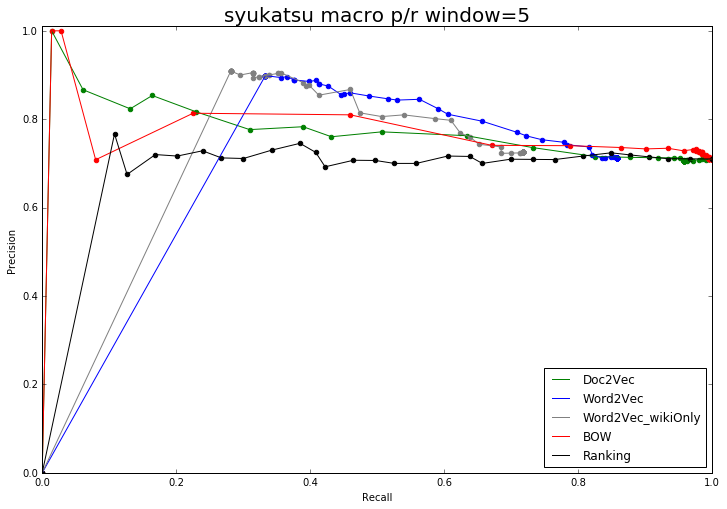

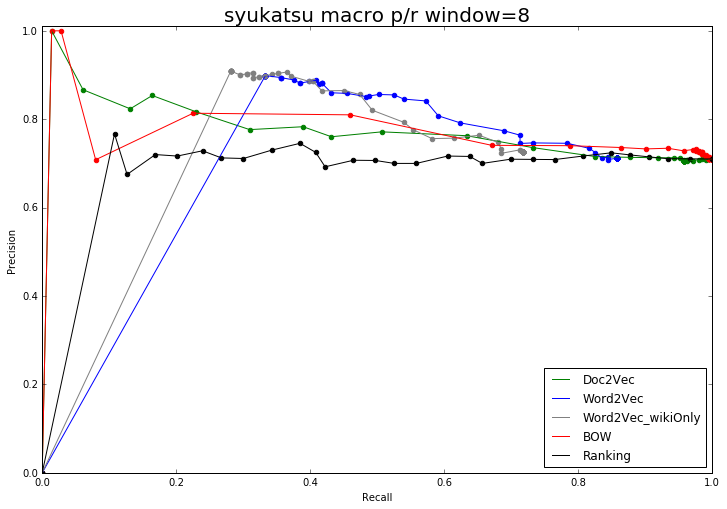

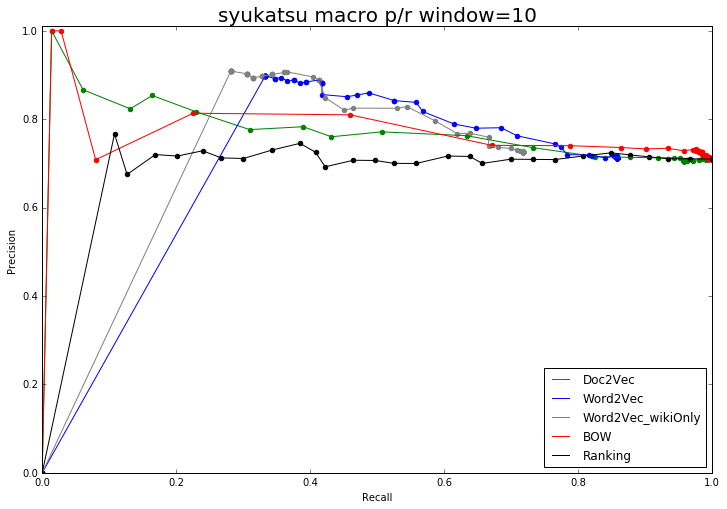

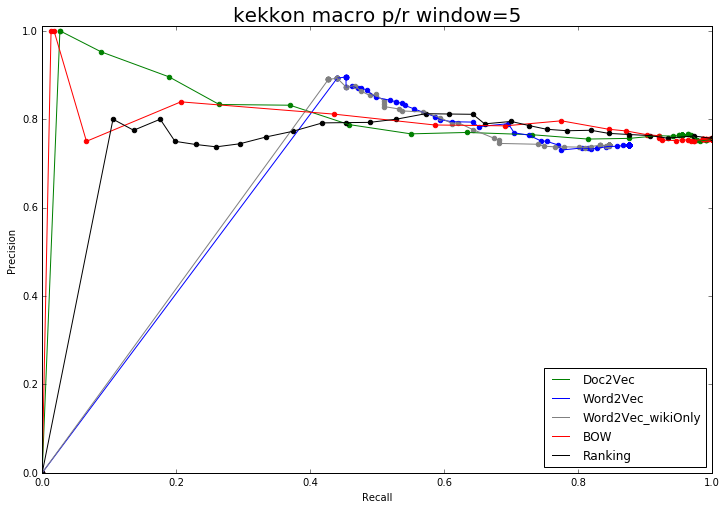

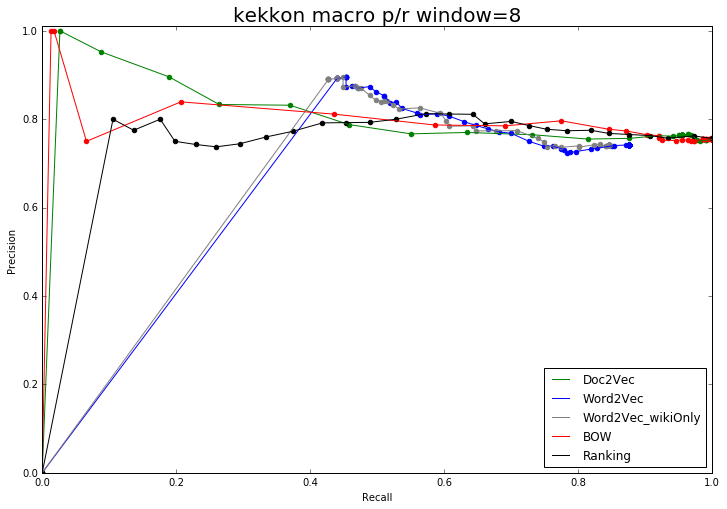

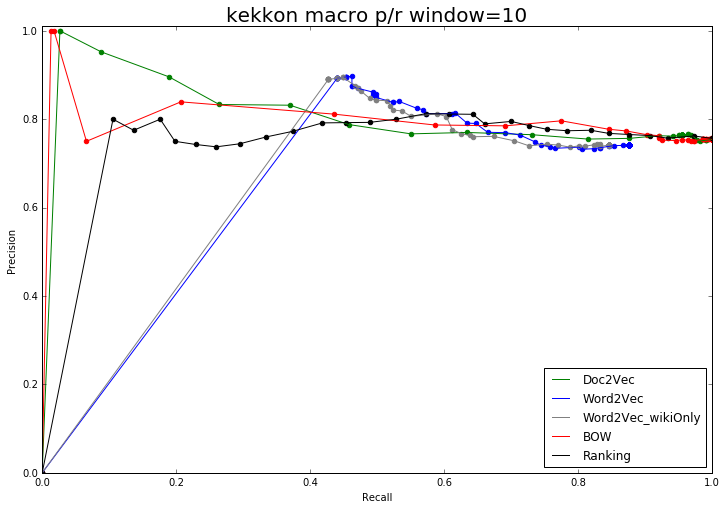

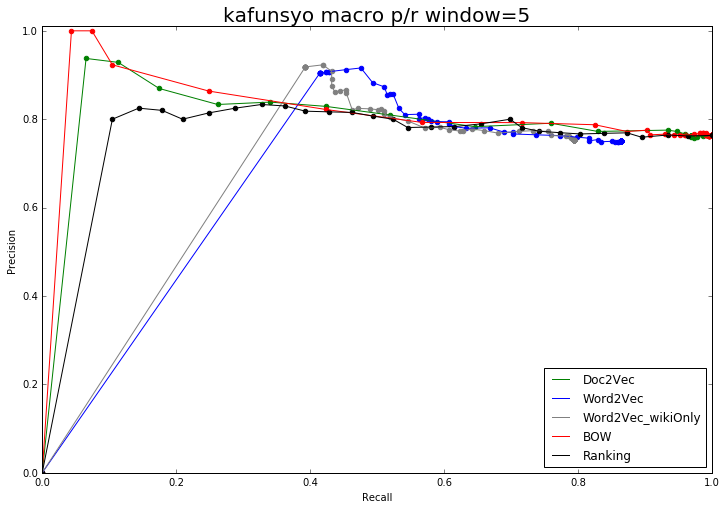

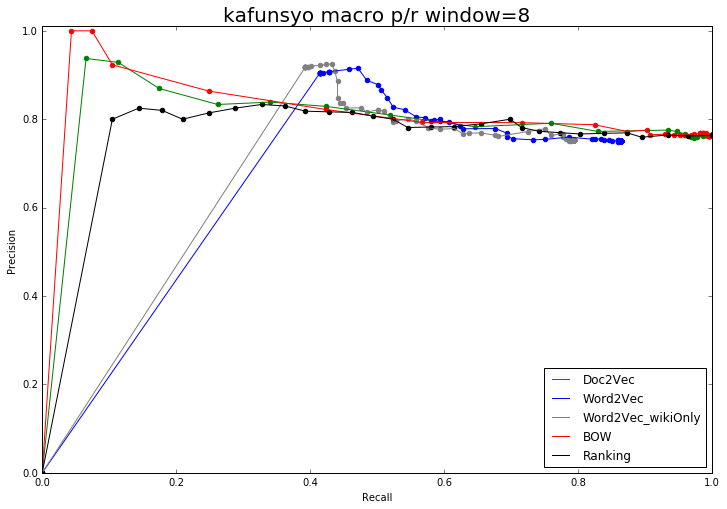

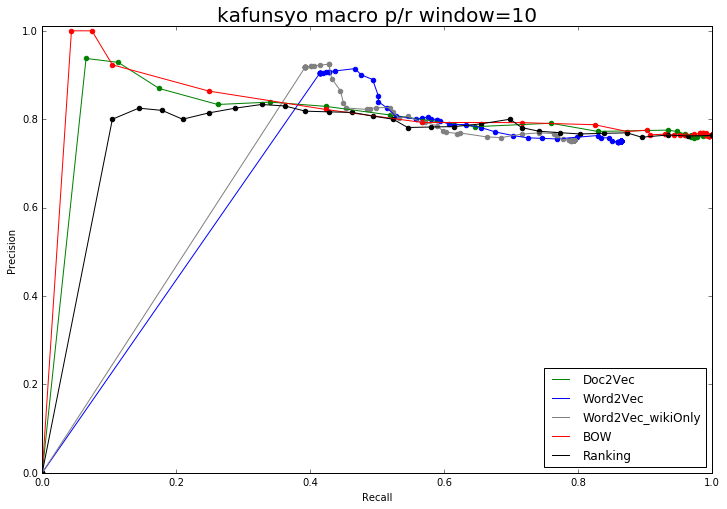

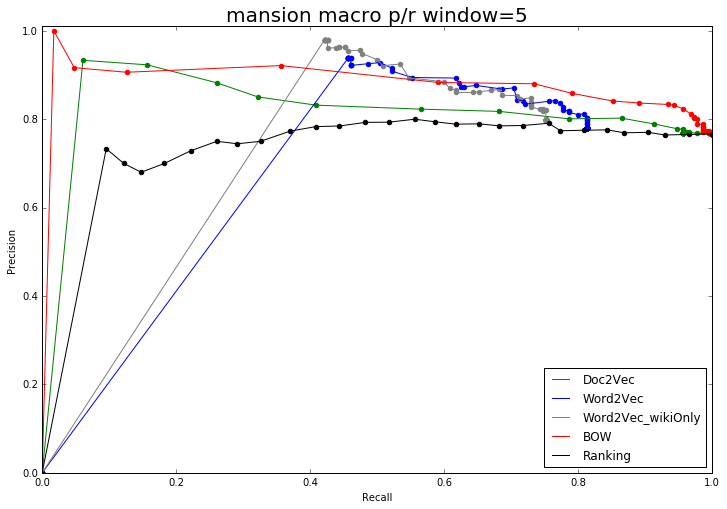

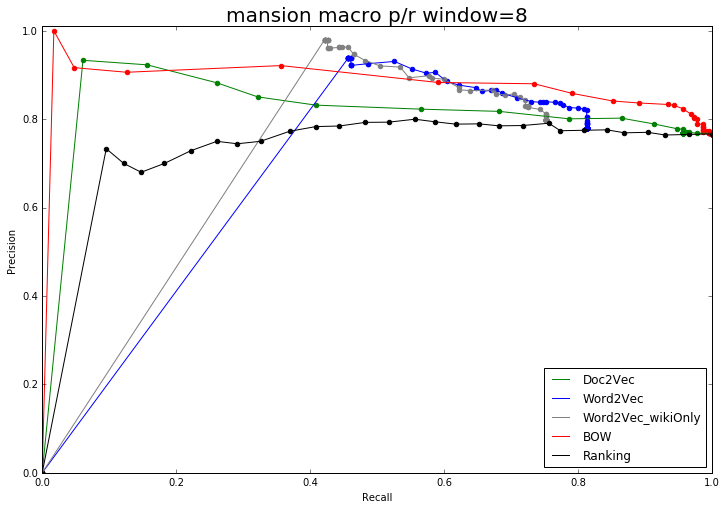

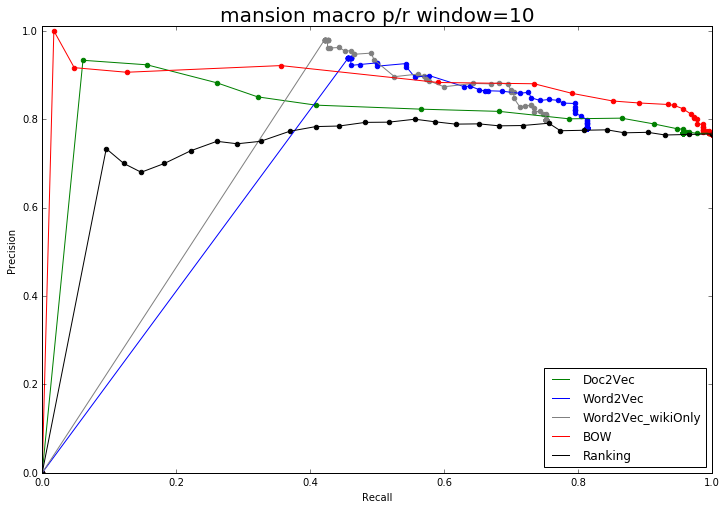

In [10]:
for name in qf_names:
    for window_size in [5, 8, 10]:
        df = pd.read_csv(os.path.join(EVAL_DIR, "stat_%s_micro_%d.csv"%(name, window_size)), index_col=False, na_values="nan")
        plot_eval(df, "%s macro p/r window=%d"%(name, window_size), "Recall", "Precision", ["green", "blue", "gray", "red", "black"])

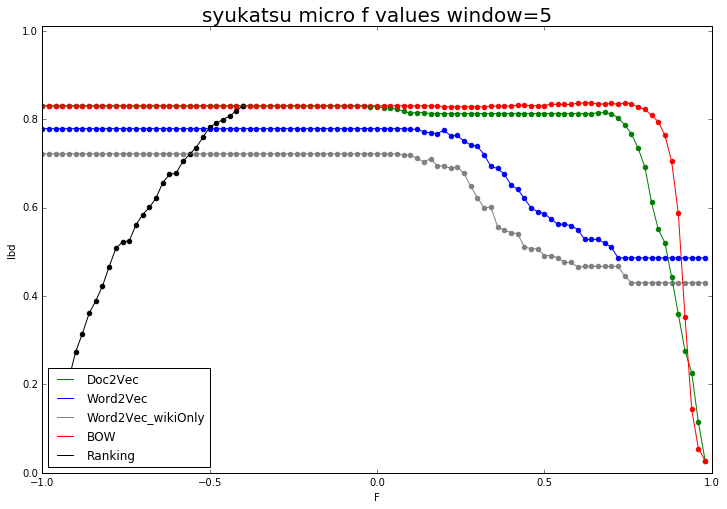

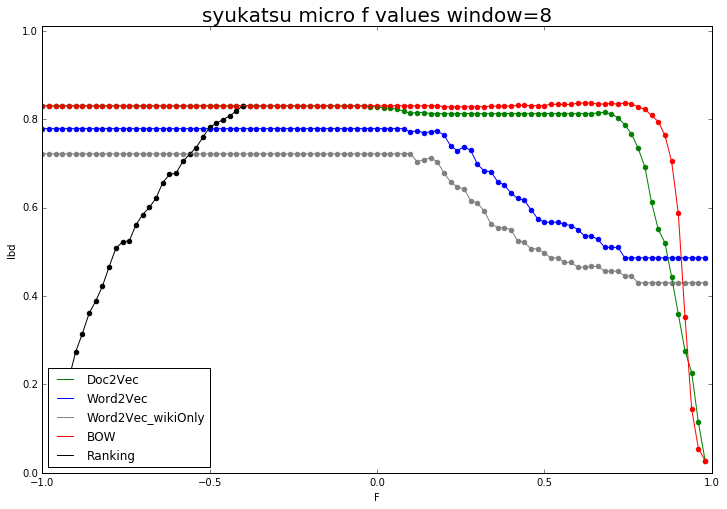

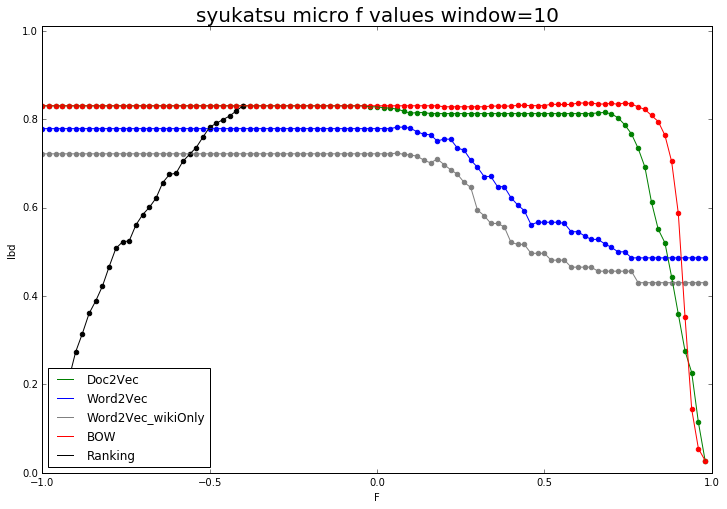

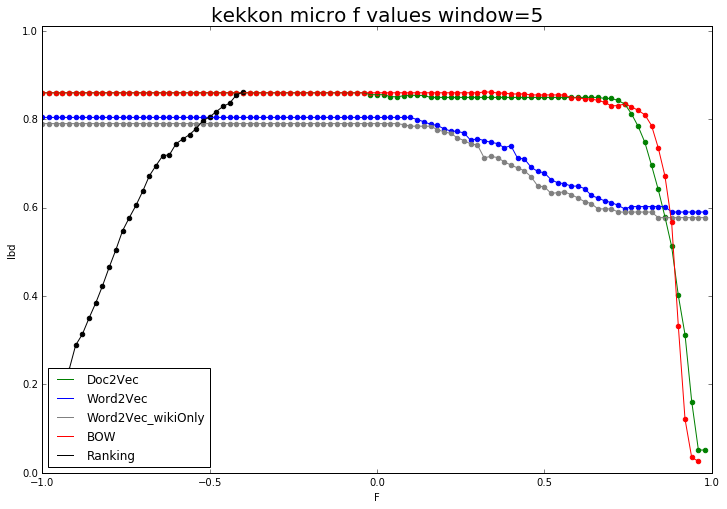

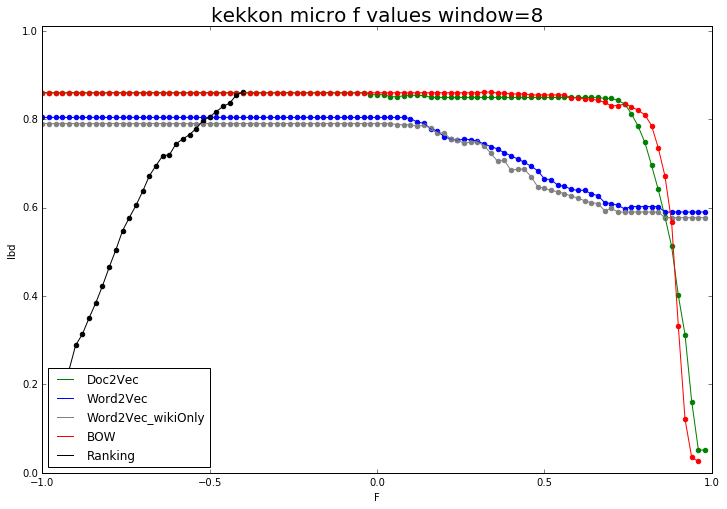

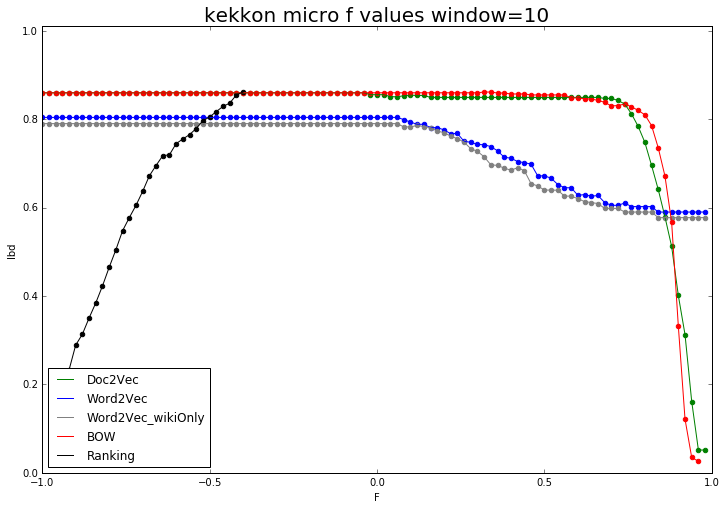

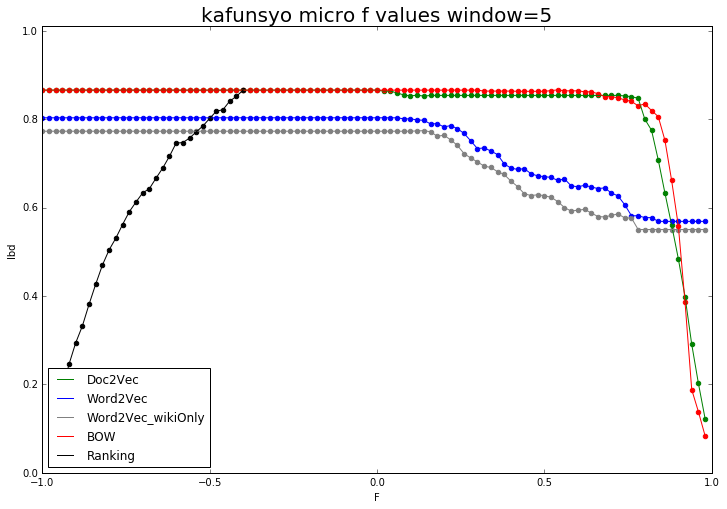

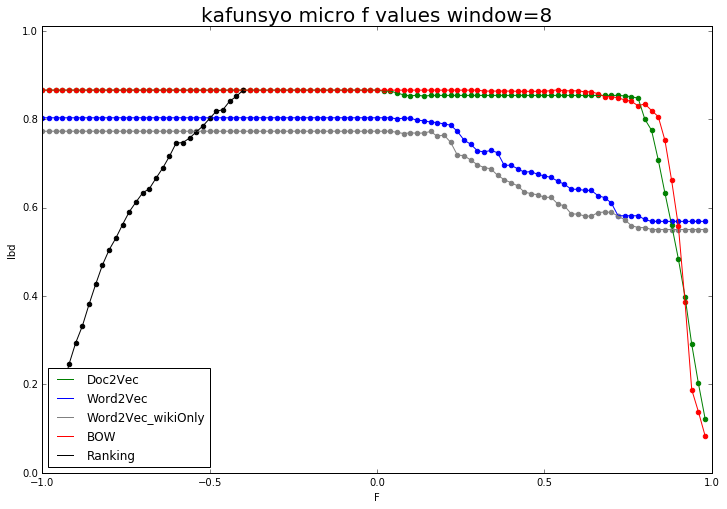

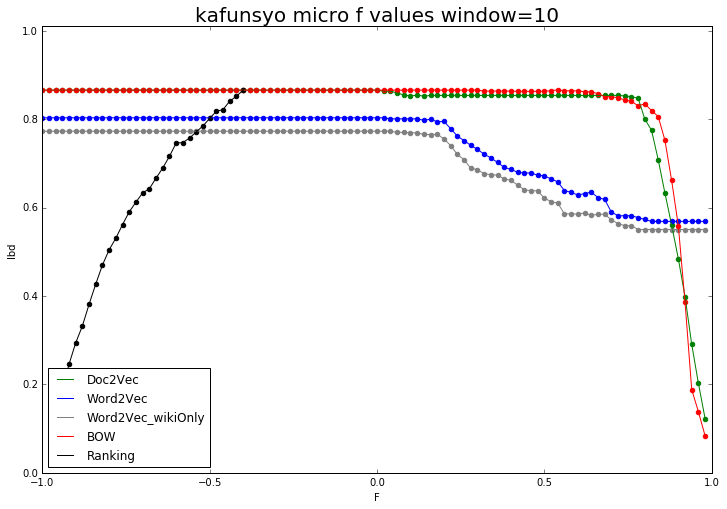

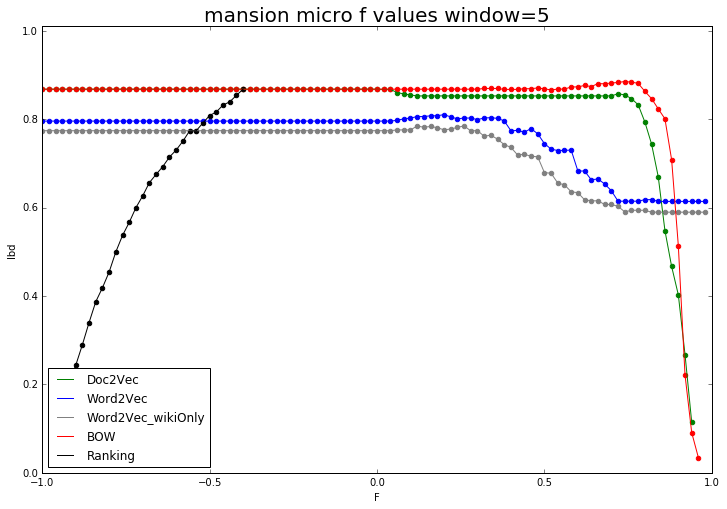

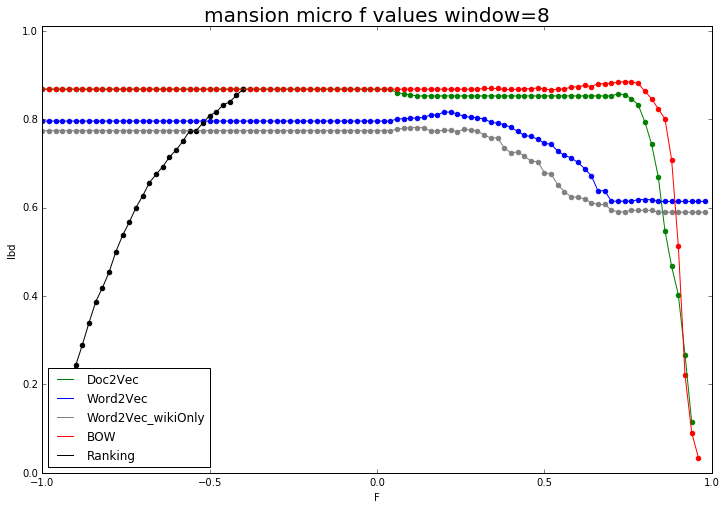

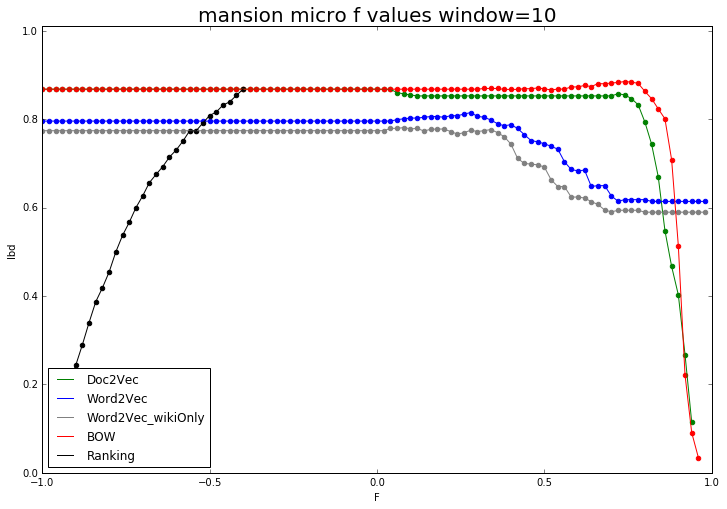

In [22]:
for name in qf_names:
    for window_size in [5, 8, 10]:
        df = pd.read_csv(os.path.join(EVAL_DIR, "stat_%s_micro_%d.csv"%(name, window_size)), index_col=False, na_values="nan")
        plot_f(df, "%s micro f values window=%d"%(name, window_size), "F", "lbd", ["green", "blue", "gray", "red", "black"])

## Temp Working Area

In [2]:
from unsupervised_models import *

In [4]:
SERIAL_DIR = os.path.join(os.getcwd(), "serialization")
WORKING_DATA_FRAME_DIR = os.path.join(os.getcwd(), "working_data")
qf_name_dict = dict([("kafunsyo", "花粉症"), ("kekkon", "結婚"), ("syukatsu", "就活"), ("3dprinter", "3dプリンタ"), ("mansion", "マンション")])

In [5]:
qf_names = ["syukatsu", "kekkon", "kafunsyo", "mansion"]
qf_name_dict = dict([("kafunsyo", "花粉症"), ("kekkon", "結婚"), ("syukatsu", "就活"), ("3dprinter", "3dプリンタ"), ("mansion", "マンション")])
qf_paths = [os.path.join(WORKING_DATA_FRAME_DIR, name) for name in qf_names]

sf_list = []
for path in qf_paths:
    sf_list.append(graphlab.SFrame(path))

In [15]:
def predict_micro(qf_name, sf, window_size):
    #d2d_vsim = pickle.load(open(os.path.join(SERIAL_DIR, "d2d_vsim_%s"%qf_name)))
    #d2d_wsim = pickle.load(open(os.path.join(SERIAL_DIR, "d2d_wsim_%s"%qf_name)))
    predictor = UnsupervisedPredictor(d2d_vsim=None, d2d_wsim=None, list_sframe_topic=DataUtility.make_list_by_topic(sf))
    predictor.qf_name = qf_name
    predictor.qf_name_JPC = qf_name_dict[qf_name]
    sa_list_label = [sf_t["label"] for sf_t in predictor.list_sframe_topic]
    eval_stat = defaultdict(list)
    
    for lbd in [0.72]:
        print qf_name, "lbd =", lbd
        eval_stat["lbd"].append(lbd)
        sa_list_prediction_sKeyWord = predictor.predict_subtopics_on_sKeyWord_vec("vec_sKeyWord_%d"%window_size, SIM_LB=lbd)
        evaluator = Evaluator(sa_list_prediction=sa_list_prediction_sKeyWord, sa_list_label=sa_list_label)
        #eval_stat["accuracy_sKeyWord"].append(evaluator.get_accuracy())
        micro_p_r = evaluator.get_micro_pre_rec()
        #print "sKeyWord", micro_p_r[0], micro_p_r[1]
        eval_stat["p_sKeyWord"].append(micro_p_r[0])
        eval_stat["r_sKeyWord"].append(micro_p_r[1])
        del evaluator
        del sa_list_prediction_sKeyWord
 
        sa_list_prediction_sKeyWord_wikiOnly = predictor.predict_subtopics_on_sKeyWord_vec("vec_sKeyWord_wikiOnly_%d"%window_size, SIM_LB=lbd)
        evaluator = Evaluator(sa_list_prediction=sa_list_prediction_sKeyWord_wikiOnly, sa_list_label=sa_list_label)
        #eval_stat["accuracy_sKeyWord"].append(evaluator.get_accuracy())
        micro_p_r = evaluator.get_micro_pre_rec()
        #print "sKeyWord", micro_p_r[0], micro_p_r[1]
        eval_stat["p_sKeyWord_wikiOnly"].append(micro_p_r[0])
        eval_stat["r_sKeyWord_wikiOnly"].append(micro_p_r[1])
        del evaluator
        del sa_list_prediction_sKeyWord_wikiOnly
    #graphlab.SFrame(eval_stat)["p_doc", "r_doc", "p_sKeyWord", "r_sKeyWord", "p_sKeyWord_wikiOnly", "r_sKeyWord_wikiOnly",\
    #"p_sKeyWord_bow", "r_sKeyWord_bow", "p_suggests", "r_suggests"].save("stat_%s_micro_%d.csv"%(qf_name, window_size), format="csv")
    #graphlab.SFrame(eval_stat).save("stat_%s_micro_%d.csv"%(qf_name, window_size), format="csv")
        print eval_stat
        
def predict_macro(qf_name, sf, window_size):
    #d2d_vsim = pickle.load(open(os.path.join(SERIAL_DIR, "d2d_vsim_%s"%qf_name)))
    #d2d_wsim = pickle.load(open(os.path.join(SERIAL_DIR, "d2d_wsim_%s"%qf_name)))
    predictor = UnsupervisedPredictor(d2d_vsim=None, d2d_wsim=None, list_sframe_topic=DataUtility.make_list_by_topic(sf))
    predictor.qf_name = qf_name
    predictor.qf_name_JPC = qf_name_dict[qf_name]
    sa_list_label = [sf_t["label"] for sf_t in predictor.list_sframe_topic]
    eval_stat = defaultdict(list)
    
    for lbd in [0.56]:
        print qf_name, "lbd =", lbd
        eval_stat["lbd"].append(lbd)
        sa_list_prediction_sKeyWord = predictor.predict_subtopics_on_sKeyWord_vec("vec_sKeyWord_%d"%window_size, SIM_LB=lbd)
        evaluator = Evaluator(sa_list_prediction=sa_list_prediction_sKeyWord, sa_list_label=sa_list_label)
        #eval_stat["accuracy_sKeyWord"].append(evaluator.get_accuracy())
        macro_p_r = evaluator.get_macro_pre_rec()
        #print "sKeyWord", micro_p_r[0], micro_p_r[1]
        eval_stat["p_sKeyWord"].append(macro_p_r[0])
        eval_stat["r_sKeyWord"].append(macro_p_r[1])
        del evaluator
        del sa_list_prediction_sKeyWord
 
        sa_list_prediction_sKeyWord_wikiOnly = predictor.predict_subtopics_on_sKeyWord_vec("vec_sKeyWord_wikiOnly_%d"%window_size, SIM_LB=lbd)
        evaluator = Evaluator(sa_list_prediction=sa_list_prediction_sKeyWord_wikiOnly, sa_list_label=sa_list_label)
        #eval_stat["accuracy_sKeyWord"].append(evaluator.get_accuracy())
        macro_p_r = evaluator.get_macro_pre_rec()
        #print "sKeyWord", micro_p_r[0], micro_p_r[1]
        eval_stat["p_sKeyWord_wikiOnly"].append(macro_p_r[0])
        eval_stat["r_sKeyWord_wikiOnly"].append(macro_p_r[1])
        del evaluator
        del sa_list_prediction_sKeyWord_wikiOnly
    #graphlab.SFrame(eval_stat)["p_doc", "r_doc", "p_sKeyWord", "r_sKeyWord", "p_sKeyWord_wikiOnly", "r_sKeyWord_wikiOnly",\
    #"p_sKeyWord_bow", "r_sKeyWord_bow", "p_suggests", "r_suggests"].save("stat_%s_micro_%d.csv"%(qf_name, window_size), format="csv")
    #graphlab.SFrame(eval_stat).save("stat_%s_micro_%d.csv"%(qf_name, window_size), format="csv")
        print eval_stat

In [27]:
predict_dump_matrix("mansion", sf_list[3], 5, 0.72, eval_scope="micro")

mansion lbd = 0.72
sKeyWord 0.921739130435 0.460869565217
sKeyWord_wikiOnly 0.961904761905 0.439130434783


In [16]:
predict_micro("mansion", sf_list[3], 5)

mansion lbd = 0.72
defaultdict(<type 'list'>, {'p_sKeyWord': [0.92173913043478262], 'r_sKeyWord': [0.46086956521739131], 'r_sKeyWord_wikiOnly': [0.43913043478260871], 'lbd': [0.72], 'p_sKeyWord_wikiOnly': [0.96190476190476193]})


In [2]:
qf_name_dict = dict([("kafunsyo", "花粉症"), ("kekkon", "結婚"), ("syukatsu", "就活"), ("3dprinter", "3dプリンタ"), ("mansion", "マンション")])
qf_names = ["kekkon"]
qf_paths = [os.path.join(os.getcwd(), "qf_sframes_readonly", qf) for qf in qf_names]
sf_list = []
for path in qf_paths:
    sf_list.append(graphlab.SFrame(path))

    
SERIAL_DIR = os.path.join(os.getcwd(), "serialization")
W2V_DIR = os.path.join(os.getcwd(), "word2vec")
D2V_DIR = os.path.join(os.getcwd(), "doc2vec")
WORKING_DATA_FRAME_DIR = os.path.join(os.getcwd(), "working_data_temp")
    

for qf_name, sf in zip(qf_names, sf_list):
    print qf_name
    sf["vec_doc"] = DataUtility.get_doc_vec_col(os.path.join(D2V_DIR, "doc2vec_model_%s"%qf_name))
    pickle.dump(list(sf["vec_doc"]), open(os.path.join(SERIAL_DIR, "vec_doc_%s"%qf_name,), 'w'))
    sf = DataUtility.get_topN(sf, 30)
    sf["suggest_f"] = DataUtility.get_suggest_f_col(sf)
    set_valid_suggest_words = DataUtility.extract_one_segment_suggest_keywords(sf, qf_name_dict[qf_name])
    pickle.dump(set_valid_suggest_words, open(os.path.join(SERIAL_DIR, "set_valid_suggest_words_%s"%qf_name), "w"))
    for size in [5, 8, 10]:
        dict_wiki_w2v = DataUtility.get_dict_suggest_word_vec(set_valid_suggest_words,\
                                                          os.path.join(W2V_DIR, "trained_models", "model_%d_%s.model"%(size, qf_name)))
        pickle.dump(dict_wiki_w2v, open(os.path.join(SERIAL_DIR, "suggest_word_vec_%s_size_%d"%(qf_name, size)), "w"))
        dict_wiki_w2v = DataUtility.get_dict_suggest_word_vec(set_valid_suggest_words,\
                                                          os.path.join(W2V_DIR, "trained_models", "model_%d_no_%s.model"%(size, qf_name)))
        pickle.dump(dict_wiki_w2v, open(os.path.join(SERIAL_DIR, "suggest_word_vec_no_%s_size_%d"%(qf_name, size)), "w"))
    print "done with serialization"

    for size in [5, 8, 10]:
        suggest_word_vec = pickle.load(open(os.path.join(SERIAL_DIR, "suggest_word_vec_%s_size_%d"%(qf_name, size)), "r"))
        sf["sKeyWord_%d"%size] = DataUtility.get_valid_sKeyWord_col(sf, qf_name_dict[qf_name], suggest_word_vec)
        sf["vec_sKeyWord_%d"%size] = DataUtility.get_valid_sKeyWord_vec_col(sf, qf_name_dict[qf_name], suggest_word_vec)
        suggest_word_vec_no = pickle.load(open(os.path.join(SERIAL_DIR, "suggest_word_vec_no_%s_size_%d"%(qf_name, size)), "r"))
        sf["sKeyWord_wikiOnly_%d"%size] = DataUtility.get_valid_sKeyWord_col(sf, qf_name_dict[qf_name], suggest_word_vec_no)
        sf["vec_sKeyWord_wikiOnly_%d"%size] = DataUtility.get_valid_sKeyWord_vec_col(sf, qf_name_dict[qf_name], suggest_word_vec_no)

    print qf_name, "dumping d2d_vsim..."
    dict_d2d_vsim = DataUtility.get_d2d_vsim_matrix(sf)
    pickle.dump(dict_d2d_vsim, open(os.path.join(SERIAL_DIR, "d2d_vsim_%s"%qf_name), 'w'))
    print qf_name, "dumping d2d_wsim..."
    dict_d2d_sim = DataUtility.get_d2d_sim_matrix(sf, "token")
    pickle.dump(dict_d2d_sim, open(os.path.join(SERIAL_DIR, "d2d_wsim_%s"%qf_name), 'w'))
    
    try:
        os.stat(WORKING_DATA_FRAME_DIR)
    except OSError:
        os.mkdir(WORKING_DATA_FRAME_DIR)
    sf.save(os.path.join(WORKING_DATA_FRAME_DIR, qf_name))

kekkon
done with serialization
kekkon dumping d2d_vsim...
kekkon dumping d2d_wsim...


In [2]:
from unsupervised_models import *
def dump_predict(qf_name, sf, window_size, lbd, rank):
    #d2d_vsim = pickle.load(open(os.path.join(SERIAL_DIR, "d2d_vsim_%s"%qf_name)))
    #d2d_wsim = pickle.load(open(os.path.join(SERIAL_DIR, "d2d_wsim_%s"%qf_name)))
    predictor = UnsupervisedPredictor(d2d_vsim=None, d2d_wsim=None, list_sframe_topic=DataUtility.make_list_by_topic(sf))
    predictor.qf_name = qf_name
    predictor.qf_name_JPC = qf_name_dict[qf_name]
    #sa_list_label = [sf_t["label"] for sf_t in predictor.list_sframe_topic]

    sa_list_prediction_sKeyWord = predictor.predict_subtopics_on_sKeyWord_vec("vec_sKeyWord_%d"%window_size, SIM_LB=lbd)
    sa_list_prediction_sKeyWord_wikiOnly = predictor.predict_subtopics_on_sKeyWord_vec("vec_sKeyWord_wikiOnly_%d"%window_size, SIM_LB=lbd)
    sa_list_prediction_doc = predictor.predict_subtopics_on_vec_doc(SIM_LB=lbd)
    sa_list_prediction_bow = predictor.predict_subtopics_on_bow(SIM_LB=lbd)
    sa_list_prediction_rank = predictor.predict_subtopics_on_topic_ranking(RANK_LB=rank)
    
    sf_retVal = None
    for sf_t, sa_sKeyWord, sa_sKeyWord_wikiOnly, sa_doc, sa_bow, sa_rank in\
    zip(predictor.list_sframe_topic ,sa_list_prediction_sKeyWord, sa_list_prediction_sKeyWord_wikiOnly, sa_list_prediction_doc, sa_list_prediction_bow, sa_list_prediction_rank):
        sf_t["prediction_sKeyWord"] = sa_sKeyWord
        sf_t["prediction_sKeyWord_wikiOnly"] = sa_sKeyWord_wikiOnly
        sf_t["prediction_doc"] = sa_doc
        sf_t["prediction_bow"] = sa_bow
        sf_t["prediction_rank"] = sa_rank
        sf_retVal = sf_t if sf_retVal is None else sf_retVal.append(sf_t)
    return sf_retVal

In [3]:
from unsupervised_models import *
qf_name_dict = dict([("kafunsyo", "花粉症"), ("kekkon", "結婚"), ("syukatsu", "就活"), ("3dprinter", "3dプリンタ"), ("mansion", "マンション")])
qf_names = ["kekkon"]
qf_paths = [os.path.join(os.getcwd(), "working_data_temp", qf) for qf in qf_names]
sf_list = []
for path in qf_paths:
    sf_list.append(graphlab.SFrame(path))
    
for name, sf in zip(qf_names, sf_list):
    sf = DataUtility.get_topN(sf, 30)
    sf_out = dump_predict(name, sf, 5, 0.7, 10)
    sf_out = sf_out["web_id", "url", "suggests", "topic", "prediction_sKeyWord", "prediction_sKeyWord_wikiOnly", "prediction_doc", "prediction_bow", "prediction_rank"]
    sf_out.save("subtopics_%s_%0.2f_%d.csv"%(name, 0.7, 10), format="csv")

In [ ]:
for t in set(sf_list[0]["topic"]):
    print t, sf_list[0].filter_by(t, "topic").shape

In [69]:

sf_t["prediction"] = print_predict("syukatsu", sf_t, 5, 0.24)
sf_t["web_id", "url", "content", "suggest_f", "label", 'sKeyWord_5', "prediction"].save("syuktasu_29.csv", format="csv")
sf_t["prediction"]

p= 0.692307692308 r= 0.9 f= 0.782608695652


dtype: int
Rows: 30
[1, 0, 0, 3, 4, 1, 2, 1, 1, 1, 5, 2, 2, 0, 0, 1, 0, 1, 0, 1, 1, 0, -1, 1, 1, 1, 1, 1, 0, 0]

In [7]:
for name, sf in zip(qf_names, sf_list):
    print name, sf.shape

syukatsu (300, 24)
kekkon (301, 24)
kafunsyo (300, 24)
mansion (300, 24)


In [24]:
sf_list[3].save("mansion_labelled.csv", format="csv")

In [5]:
def count_ref_binary_labels(sf):
    retVal = []
    for t in set(sf["topic"]):
        sf_t = sf[sf["topic"]==t]
        retVal.extend(list(UnsupervisedPredictor.get_binary_classes_from_labels(sf_t["label"])))
    return retVal

In [6]:
for name, sf in zip(qf_names, sf_list):
    counter = Counter(count_ref_binary_labels(sf))
    print name, counter

syukatsu Counter({1: 213, 0: 87})
kekkon Counter({1: 227, 0: 74})
kafunsyo Counter({1: 229, 0: 71})
mansion Counter({1: 230, 0: 70})


In [9]:
def count_major_minor_embedded(sf):
    major_embedded, minor_embedded = 0, 0
    major_embedded_wikiOnly, minor_embedded_wikiOnly = 0, 0
    for t in set(sf["topic"]):
        sf_t = sf[sf["topic"]==t]
        mask_class = UnsupervisedPredictor.get_binary_classes_from_labels(sf_t["label"])
        mask_embedded = sf_t["vec_sKeyWord_5"].apply(lambda x: len(x)>0)
        mask_embedded_wikiOnly = sf_t["vec_sKeyWord_wikiOnly_5"].apply(lambda x: len(x)>0)
        count_embedded_major = ((mask_class==1) & (mask_embedded==1)).nnz()
        count_embedded_minor = ((mask_class==0) & (mask_embedded==1)).nnz()
        count_embedded_major_wikiOnly = ((mask_class==1) & (mask_embedded_wikiOnly==1)).nnz()
        count_embedded_minor_wikiOnly = ((mask_class==0) & (mask_embedded_wikiOnly==1)).nnz()
        major_embedded += count_embedded_major
        minor_embedded += count_embedded_minor
        major_embedded_wikiOnly += count_embedded_major_wikiOnly
        minor_embedded_wikiOnly += count_embedded_minor_wikiOnly
    return major_embedded, minor_embedded, major_embedded_wikiOnly, minor_embedded_wikiOnly

In [10]:
for name, sf in zip(qf_names, sf_list):
    print name
    print count_major_minor_embedded(sf)

syukatsu
(183, 74, 153, 58)
kekkon
(199, 69, 192, 67)
kafunsyo
(198, 66, 182, 60)
mansion
(187, 53, 173, 44)
